# Add Imports

In [ ]:
# !pip cache purge
# !pip install numpy==1.24 --user
# !pip install --upgrade --force-reinstall scipy gensim --user
# !pip install --upgrade paramiko
# !pip install seaborn --upgrade
# !pip install pandas --upgrade

In [2]:
# General Utilities
import time
import string
import re
import os
from collections import Counter, defaultdict
import math
import warnings

# Data Manipulation and Numerical Operations
import pandas as pd
import numpy as np

# Web Requests and Parsing
import requests
from bs4 import BeautifulSoup

# Natural Language Processing (NLP)
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from textblob import TextBlob
from gensim import corpora, models
import spacy
nlp = spacy.load('en_core_web_sm')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud
import missingno as msno
import pyLDAvis
import pyLDAvis.gensim_models
import pyLDAvis.lda_model
from graphviz import Digraph

# Statistical Analysis
from scipy import stats
from scipy.stats import skew, kurtosis, t, zscore
import statsmodels.api as sm

# Time Series Analysis
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, acf, pacf

# Machine Learning - Modeling and Evaluation
from sklearn.decomposition import LatentDirichletAllocation, NMF, TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, LeaveOneOut
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight


## List of Stocks to Analyze

| Sector | Stock 1 Name | Stock 1 Ticker | Stock 2 Name | Stock 2 Ticker |
|---|---|---|---|---|
| Technology | Apple | AAPL | Microsoft | MSFT |
| Healthcare | Johnson & Johnson | JNJ | UnitedHealth Group | UNH |
| Financials | JPMorgan Chase & Co. | JPM | Bank of America | BAC |
| Consumer Discretionary | Amazon.com | AMZN | Home Depot | HD |
| Industrials | Boeing | BA | Caterpillar | CAT |
| Consumer Staples | Procter & Gamble | PG | Coca-Cola | KO |
| Utilities | NextEra Energy | NEE | Duke Energy | DUK |
| Materials | Dow Inc. | DOW | Nucor Corporation | NUE |
| Communication Services | Verizon Communications | VZ | Comcast Corporation | CMCSA |
| Real Estate | American Tower Corporation | AMT | Prologis | PLD |
| Energy | Exxon Mobil Corporation | XOM | Chevron Corporation | CVX |tion | CVX |tion (CVX) |

# Load Data

In [3]:
# Load CSV files into DataFrames
daily_data_df = pd.read_csv("daily_stock_data.csv")
eight_k_sections_df = pd.read_csv("form_8k_disclosures.csv")

In [4]:
# Display first rows to verify data
daily_data_df.head()

,Date,Symbol,Open,High,Low,Close,Volume
0,2024-11-13 00:00:00+00:00,AAPL,223.95,226.65,222.76,225.12,47686733.0
1,2024-11-12 00:00:00+00:00,AAPL,224.55,225.59,223.36,224.23,40375300.0
2,2024-11-11 00:00:00+00:00,AAPL,225.00,225.70,221.50,224.23,41949000.0
3,2024-11-08 00:00:00+00:00,AAPL,227.17,228.66,226.41,226.96,38308700.0
4,2024-11-07 00:00:00+00:00,AAPL,224.63,227.88,224.57,227.48,42083800.0


In [5]:
# Display first rows to verify data
eight_k_sections_df.head()

,ticker,filing_type,filing_url,accession_number,disclosure_date,section,content
0,AAPL,8-K,https://www.sec.gov/Archives/edgar/data/320193...,0000320193-24-000120,2024-10-31T16:30:25-04:00,2.2,Item 2.02 Results of Operations and Financial ...
1,AAPL,8-K,https://www.sec.gov/Archives/edgar/data/320193...,0000320193-24-000120,2024-10-31T16:30:25-04:00,9.1,Item 9.01 Financial Statements and Exhibits. \...
2,AAPL,8-K,https://www.sec.gov/Archives/edgar/data/320193...,0001140361-24-040659,2024-09-10T09:06:34-04:00,7.1,Item 7.01 Regulation FD Disclosure.\n\nOn Augu...
3,AAPL,8-K,https://www.sec.gov/Archives/edgar/data/320193...,0001140361-24-038601,2024-08-26T17:20:33-04:00,5.2,Item 5.02 Departure of Directors or Certain Of...
4,AAPL,8-K,https://www.sec.gov/Archives/edgar/data/320193...,0001140361-24-038403,2024-08-23T16:30:44-04:00,5.3,Item 5.03 Amendments to Articles of Incorporat...


## Establishing Text Cleaning and Tokenization Functions for SEC Data
*This code defines functions to clean, tokenize, and lemmatize SEC filing text, removing boilerplate and irrelevant content. These functions form a preprocessing pipeline to prepare text for analysis.*

In [6]:
# Download NLTK data
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('stopwords', quiet=True)

# Load the English stopwords from NLTK
stopwords_list = stopwords.words('english')

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Define the stopwords, including custom stopwords specific to the domain
custom_stopwords = set(stopwords.words('english')).union({
    'herein', 'thereof', 'aforementioned', 'form', '8-k', 'nvidia', 'corporation', 'securities', 'exchange',
    'commission', 'share', 'meeting', 'vote', 'registrant', 'item', 'section', 'pursuant', 'act', 'inc', 'llc'
})

def clean_text(text):
    """Performs enhanced text cleaning to remove legal boilerplate and irrelevant characters."""
    # Remove common boilerplate phrases and legal text patterns
    text = re.sub(r'UNITED STATES SECURITIES AND EXCHANGE COMMISSION', '', text, flags=re.IGNORECASE)
    text = re.sub(r'FORM 8-K', '', text, flags=re.IGNORECASE)
    text = re.sub(r'CURRENT REPORT PURSUANT TO SECTION [0-9]+ OF THE SECURITIES EXCHANGE ACT OF 1934', '', text, flags=re.IGNORECASE)

    # Add spaces between numbers and words (ensures proper spacing in cases like 'for398number')
    text = re.sub(r'(?<=[a-zA-Z])(?=\d)', ' ', text)
    text = re.sub(r'(?<=\d)(?=[a-zA-Z])', ' ', text)
    
    # Normalize dates and numbers
    text = re.sub(r'\b\d{4}-\d{2}-\d{2}\b', ' [DATE] ', text)
    text = re.sub(r'\b\d+\b', '', text)
    
    # Remove unwanted characters and special symbols
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'\\x\w{2}', '', text)
    text = re.sub(r'[☐]', '', text)
    
    # Remove punctuation, while keeping periods for potential sentence segmentation
    text = re.sub(r'[^\w\s\.\-]', '', text)
    
    # Remove single characters followed by a period (e.g., 'a.', 'm.', 'c.')
    text = re.sub(r'\b[a-zA-Z]\.\b', '', text)
    
    return text

def tokenize(text):
    """Tokenizes, lemmatizes, and removes stopwords, including filtering out single characters."""
    tokens = re.split(r'\s+', text.lower())
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in custom_stopwords and len(token) > 1]
    return tokens

def prepare(text, pipeline):
    """Prepares text by applying a sequence of cleaning and transformation steps."""
    for transform in pipeline:
        text = transform(text)
    return text

# Define the text preprocessing pipeline
pipeline = [clean_text, tokenize]

# Function to preprocess the 'Disclosure Text' column in the existing DataFrame
def preprocess_disclosure_text(df):
    """Applies text preprocessing to the 'Disclosure Text' column of the existing DataFrame."""
    df['Processed Disclosure Text'] = df['Disclosure Text'].apply(
        lambda x: ' '.join(prepare(x, pipeline)) if isinstance(x, str) else ''
    )
    return df

# Begin Preprocessing

### Explore Data Frame Dimensions

In [7]:
# Check the dimensions of the 'Disclosures' DataFrame
eight_k_sections_df.shape

(1254, 7)

In [8]:
# Check the dimensions of the 'Stock Data' DataFrame
daily_data_df.shape

(11066, 7)

### Check for Missing Values

In [9]:
# Count missing values in each column of the 'Disclosures' DataFrame
eight_k_sections_df.isnull().sum()

ticker              0
filing_type         0
filing_url          0
accession_number    0
disclosure_date     0
section             0
content             0
dtype: int64

In [10]:
# Count missing values in each column of the 'Stock Data' DataFrame
daily_data_df.isnull().sum()

Date      0
Symbol    0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

### Check for Duplicate Values

In [11]:
# Count duplicate rows in the 'Disclosures' DataFrame
disclosure_dups = eight_k_sections_df.duplicated().sum()
disclosure_dups

17

In [12]:
# Count duplicate rows in the 'Stock Data' DataFrame
stock_dups = daily_data_df.duplicated().sum()
stock_dups

0

### Handle Duplicate Values

In [13]:
# Display duplicate rows
discl_dups_disp = eight_k_sections_df[eight_k_sections_df.duplicated()]
discl_dups_disp.head(6)

,ticker,filing_type,filing_url,accession_number,disclosure_date,section,content
780,DUK,8-K,https://www.sec.gov/Archives/edgar/data/30371/...,0001104659-23-126586,2023-12-18T06:45:18-05:00,7.1,Item 7.01. Regulation FD Disclosure. \n\n&#160...
781,DUK,8-K,https://www.sec.gov/Archives/edgar/data/30371/...,0001104659-23-126586,2023-12-18T06:45:18-05:00,9.1,Item 9.01. Financial Statements and Exhibits. ...
787,DUK,8-K,https://www.sec.gov/Archives/edgar/data/30371/...,0001326160-23-000181,2023-08-28T16:17:20-04:00,7.1,Item 7.01. Regulation FD Disclosure. \n\nOn Au...
790,DUK,8-K,https://www.sec.gov/Archives/edgar/data/30371/...,0001104659-23-094252,2023-08-22T16:40:56-04:00,7.1,Item 7.01. Regulation FD Disclosure. \n\n&#160...
791,DUK,8-K,https://www.sec.gov/Archives/edgar/data/30371/...,0001104659-23-094252,2023-08-22T16:40:56-04:00,9.1,Item 9.01. Financial Statements and Exhibits. ...
816,DUK,8-K,https://www.sec.gov/Archives/edgar/data/17797/...,0001104659-23-040516,2023-04-03T06:55:28-04:00,8.1,Item 8.01. Other Events. \n\n&#160;\n\nAmendme...


***Determined that rows are not true duplicates. Although 'ticker', 'filing_type', 'filing_url', 'accession_number', 'disclosure_date' are the same, the 'section' and 'content' columns indicate they represent different disclosures.***

## Data Preparation: Cleaning and Wrangling 

### Perform Text Cleaning, Preprocessing, and Tokenization

In [14]:
# Preprocesses the 'content' column of the DataFrame
def preprocess_disclosure_text(df):
    df['Processed Disclosure Text'] = df['content'].apply(
        lambda x: ' '.join(prepare(x, pipeline)) if isinstance(x, str) else ''
    )
    return df

# Apply preprocessing to 'content' column
eight_k_sections_df = preprocess_disclosure_text(eight_k_sections_df)

# Verify the processed column
eight_k_sections_df.head()

,ticker,filing_type,filing_url,accession_number,disclosure_date,section,content,Processed Disclosure Text
0,AAPL,8-K,https://www.sec.gov/Archives/edgar/data/320193...,0000320193-24-000120,2024-10-31T16:30:25-04:00,2.2,Item 2.02 Results of Operations and Financial ...,result operation financial condition. october ...
1,AAPL,8-K,https://www.sec.gov/Archives/edgar/data/320193...,0000320193-24-000120,2024-10-31T16:30:25-04:00,9.1,Item 9.01 Financial Statements and Exhibits. \...,financial statement exhibits. exhibits. exhibi...
2,AAPL,8-K,https://www.sec.gov/Archives/edgar/data/320193...,0001140361-24-040659,2024-09-10T09:06:34-04:00,7.1,Item 7.01 Regulation FD Disclosure.\n\nOn Augu...,regulation fd disclosure. august european anno...
3,AAPL,8-K,https://www.sec.gov/Archives/edgar/data/320193...,0001140361-24-038601,2024-08-26T17:20:33-04:00,5.2,Item 5.02 Departure of Directors or Certain Of...,departure director certain officer election di...
4,AAPL,8-K,https://www.sec.gov/Archives/edgar/data/320193...,0001140361-24-038403,2024-08-23T16:30:44-04:00,5.3,Item 5.03 Amendments to Articles of Incorporat...,amendment article incorporation bylaw change f...


### Data Type Handling

**'Disclosures' DataFrame**

In [15]:
# Convert 'disclosure_date' to datetime and remove timezone
eight_k_sections_df['disclosure_date'] = pd.to_datetime(eight_k_sections_df['disclosure_date'], utc=True).dt.tz_convert(None).dt.normalize()

# Display Results
eight_k_sections_df.head()

,ticker,filing_type,filing_url,accession_number,disclosure_date,section,content,Processed Disclosure Text
0,AAPL,8-K,https://www.sec.gov/Archives/edgar/data/320193...,0000320193-24-000120,2024-10-31,2.2,Item 2.02 Results of Operations and Financial ...,result operation financial condition. october ...
1,AAPL,8-K,https://www.sec.gov/Archives/edgar/data/320193...,0000320193-24-000120,2024-10-31,9.1,Item 9.01 Financial Statements and Exhibits. \...,financial statement exhibits. exhibits. exhibi...
2,AAPL,8-K,https://www.sec.gov/Archives/edgar/data/320193...,0001140361-24-040659,2024-09-10,7.1,Item 7.01 Regulation FD Disclosure.\n\nOn Augu...,regulation fd disclosure. august european anno...
3,AAPL,8-K,https://www.sec.gov/Archives/edgar/data/320193...,0001140361-24-038601,2024-08-26,5.2,Item 5.02 Departure of Directors or Certain Of...,departure director certain officer election di...
4,AAPL,8-K,https://www.sec.gov/Archives/edgar/data/320193...,0001140361-24-038403,2024-08-23,5.3,Item 5.03 Amendments to Articles of Incorporat...,amendment article incorporation bylaw change f...


**'Stock Data' DataFrame**

In [16]:
# Convert 'Date' to datetime with UTC, set time to midnight
daily_data_df['Date'] = pd.to_datetime(daily_data_df['Date'], utc=True).dt.tz_convert(None).dt.normalize()

# Display Results
daily_data_df.head()

,Date,Symbol,Open,High,Low,Close,Volume
0,2024-11-13,AAPL,223.95,226.65,222.76,225.12,47686733.0
1,2024-11-12,AAPL,224.55,225.59,223.36,224.23,40375300.0
2,2024-11-11,AAPL,225.00,225.70,221.50,224.23,41949000.0
3,2024-11-08,AAPL,227.17,228.66,226.41,226.96,38308700.0
4,2024-11-07,AAPL,224.63,227.88,224.57,227.48,42083800.0


### Feature Engineering

**Date Decomposition**

In [17]:
# Extract year, month, and day components
eight_k_sections_df['year'] = eight_k_sections_df['disclosure_date'].dt.year
eight_k_sections_df['month'] = eight_k_sections_df['disclosure_date'].dt.month
eight_k_sections_df['day'] = eight_k_sections_df['disclosure_date'].dt.day

eight_k_sections_df = eight_k_sections_df[['ticker', 'disclosure_date', 'year', 'month', 'day', 
                                           'filing_type', 'filing_url', 'accession_number', 
                                           'section', 'content', 'Processed Disclosure Text']]

# Display results
eight_k_sections_df.head()


,ticker,disclosure_date,year,month,day,filing_type,filing_url,accession_number,section,content,Processed Disclosure Text
0,AAPL,2024-10-31,2024,10,31,8-K,https://www.sec.gov/Archives/edgar/data/320193...,0000320193-24-000120,2.2,Item 2.02 Results of Operations and Financial ...,result operation financial condition. october ...
1,AAPL,2024-10-31,2024,10,31,8-K,https://www.sec.gov/Archives/edgar/data/320193...,0000320193-24-000120,9.1,Item 9.01 Financial Statements and Exhibits. \...,financial statement exhibits. exhibits. exhibi...
2,AAPL,2024-09-10,2024,9,10,8-K,https://www.sec.gov/Archives/edgar/data/320193...,0001140361-24-040659,7.1,Item 7.01 Regulation FD Disclosure.\n\nOn Augu...,regulation fd disclosure. august european anno...
3,AAPL,2024-08-26,2024,8,26,8-K,https://www.sec.gov/Archives/edgar/data/320193...,0001140361-24-038601,5.2,Item 5.02 Departure of Directors or Certain Of...,departure director certain officer election di...
4,AAPL,2024-08-23,2024,8,23,8-K,https://www.sec.gov/Archives/edgar/data/320193...,0001140361-24-038403,5.3,Item 5.03 Amendments to Articles of Incorporat...,amendment article incorporation bylaw change f...


In [18]:
# Extract year, month, and day components
daily_data_df['year'] = daily_data_df['Date'].dt.year
daily_data_df['month'] = daily_data_df['Date'].dt.month
daily_data_df['day'] = daily_data_df['Date'].dt.day

daily_data_df = daily_data_df[['Date', 'year', 'month', 'day', 'Symbol', 'Open', 'High', 'Low', 'Close', 'Volume']]

# Display results
daily_data_df.head()

,Date,year,month,day,Symbol,Open,High,Low,Close,Volume
0,2024-11-13,2024,11,13,AAPL,223.95,226.65,222.76,225.12,47686733.0
1,2024-11-12,2024,11,12,AAPL,224.55,225.59,223.36,224.23,40375300.0
2,2024-11-11,2024,11,11,AAPL,225.00,225.70,221.50,224.23,41949000.0
3,2024-11-08,2024,11,8,AAPL,227.17,228.66,226.41,226.96,38308700.0
4,2024-11-07,2024,11,7,AAPL,224.63,227.88,224.57,227.48,42083800.0


**Daily Performance Features**

In [19]:
# Feature: Gain or Loss Day (1 for gain, 0 for loss) based on Open vs Close
daily_data_df['gain_loss'] = (daily_data_df['Close'] > daily_data_df['Open']).astype(int)

# Feature: Daily High vs Previous Day High (1 for higher, 0 for lower)
daily_data_df['high_vs_prev_day'] = (daily_data_df['High'] > daily_data_df['High'].shift(1)).astype(int)

# Feature: Daily Low vs Previous Day Low (1 for higher, 0 for lower)
daily_data_df['low_vs_prev_day'] = (daily_data_df['Low'] > daily_data_df['Low'].shift(1)).astype(int)

# Feature: Daily Volume vs Previous Day Volume (1 for higher, 0 for lower)
daily_data_df['volume_vs_prev_day'] = (daily_data_df['Volume'] > daily_data_df['Volume'].shift(1)).astype(int)

# Feature: Percentage Change in Close Price from Previous Day
daily_data_df['pct_close_change'] = daily_data_df['Close'].pct_change() * 100

# Feature: Percentage Change in Volume from Previous Day
daily_data_df['pct_volume_change'] = daily_data_df['Volume'].pct_change() * 100

# Round percentage change features to 4 decimal places
daily_data_df['pct_close_change'] = daily_data_df['pct_close_change'].round(4)
daily_data_df['pct_volume_change'] = daily_data_df['pct_volume_change'].round(4)

# Display results
daily_data_df.head()

,Date,year,month,day,Symbol,Open,High,Low,Close,Volume,gain_loss,high_vs_prev_day,low_vs_prev_day,volume_vs_prev_day,pct_close_change,pct_volume_change
0,2024-11-13,2024,11,13,AAPL,223.95,226.65,222.76,225.12,47686733.0,1,0,0,0,NaN,NaN
1,2024-11-12,2024,11,12,AAPL,224.55,225.59,223.36,224.23,40375300.0,0,0,1,0,-0.3953,-15.3322
2,2024-11-11,2024,11,11,AAPL,225.00,225.70,221.50,224.23,41949000.0,0,1,0,1,0.0000,3.8977
3,2024-11-08,2024,11,8,AAPL,227.17,228.66,226.41,226.96,38308700.0,0,1,1,0,1.2175,-8.6779
4,2024-11-07,2024,11,7,AAPL,224.63,227.88,224.57,227.48,42083800.0,1,0,0,1,0.2291,9.8544


### Check Data Types

In [20]:
# Check data types of each column in the 'Disclosures' DataFrame
eight_k_sections_df.dtypes

ticker                               object
disclosure_date              datetime64[ns]
year                                  int32
month                                 int32
day                                   int32
filing_type                          object
filing_url                           object
accession_number                     object
section                             float64
content                              object
Processed Disclosure Text            object
dtype: object

In [21]:
# Check data types of each column in the 'Stock Data' DataFrame
daily_data_df.dtypes

Date                  datetime64[ns]
year                           int32
month                          int32
day                            int32
Symbol                        object
Open                         float64
High                         float64
Low                          float64
Close                        float64
Volume                       float64
gain_loss                      int32
high_vs_prev_day               int32
low_vs_prev_day                int32
volume_vs_prev_day             int32
pct_close_change             float64
pct_volume_change            float64
dtype: object

### Check Date Range for Both Data Frames to Ensure Consistency

In [22]:
# Check date range for 'disclosure_date' in 'Disclosures' DataFrame
disclosures_date_range = (eight_k_sections_df['disclosure_date'].min(), eight_k_sections_df['disclosure_date'].max())
print("Disclosures Date Range:", disclosures_date_range)

# Check date range for 'Date' in 'Stock Data' DataFrame
stock_data_date_range = (daily_data_df['Date'].min(), daily_data_df['Date'].max())
print("Stock Data Date Range:", stock_data_date_range)

Disclosures Date Range: (Timestamp('2022-11-15 00:00:00'), Timestamp('2024-11-12 00:00:00'))
Stock Data Date Range: (Timestamp('2022-11-14 00:00:00'), Timestamp('2024-11-13 00:00:00'))


**Remove 'Out-of-Range' Dates**

In [23]:
# Find the overlapping date range
start_date = max(eight_k_sections_df['disclosure_date'].min(), daily_data_df['Date'].min())
end_date = min(eight_k_sections_df['disclosure_date'].max(), daily_data_df['Date'].max())

# Filter each DataFrame to the overlapping date range
eight_k_sections_df = eight_k_sections_df[(eight_k_sections_df['disclosure_date'] >= start_date) & 
                                          (eight_k_sections_df['disclosure_date'] <= end_date)]
daily_data_df = daily_data_df[(daily_data_df['Date'] >= start_date) & 
                              (daily_data_df['Date'] <= end_date)]

# Verify the date range for each DataFrame
print("Adjusted Disclosures Date Range:", (eight_k_sections_df['disclosure_date'].min(), eight_k_sections_df['disclosure_date'].max()))
print("Adjusted Stock Data Date Range:", (daily_data_df['Date'].min(), daily_data_df['Date'].max()))

Adjusted Disclosures Date Range: (Timestamp('2022-11-15 00:00:00'), Timestamp('2024-11-12 00:00:00'))
Adjusted Stock Data Date Range: (Timestamp('2022-11-15 00:00:00'), Timestamp('2024-11-12 00:00:00'))


### Descriptive Statistics

**'Disclosures' DataFrame**


In [24]:
# Define descriptive statistics function
def descriptive_stats(tokens, num_tokens=5, verbose=False):
    """Calculates descriptive stats for a list of tokens."""
    total_tokens = len(tokens)
    unique_tokens = len(set(tokens))
    lexical_diversity = unique_tokens / total_tokens if total_tokens > 0 else 0
    total_characters = sum(len(token) for token in tokens)
    token_counts = Counter(tokens)
    most_common_tokens = token_counts.most_common(num_tokens)
    
    return {
        "Total Tokens": total_tokens,
        "Unique Tokens": unique_tokens,
        "Lexical Diversity": lexical_diversity,
        "Total Characters": total_characters,
        "Most Common Tokens": most_common_tokens
    }

# Preprocess and tokenize 'Processed Disclosure Text' column
eight_k_sections_df['Token Stats'] = eight_k_sections_df['Processed Disclosure Text'].apply(
    lambda text: descriptive_stats(text.split()) if isinstance(text, str) else None
)

# Convert list of dictionaries to a DataFrame
summary_df = pd.DataFrame(eight_k_sections_df['Token Stats'].tolist())

# Calculate summary statistics
summary_table = summary_df[["Total Tokens", "Unique Tokens", "Lexical Diversity", "Total Characters"]].agg(
    ['mean', 'median', 'std', 'min', 'max']
)

# Add quartiles
summary_table.loc['25%'] = summary_df[["Total Tokens", "Unique Tokens", "Lexical Diversity", "Total Characters"]].quantile(0.25)
summary_table.loc['75%'] = summary_df[["Total Tokens", "Unique Tokens", "Lexical Diversity", "Total Characters"]].quantile(0.75)

# Round all values to 4 decimal places
summary_table = summary_table.round(4)

print("8-K Token Summary Statistics")
summary_table

8-K Token Summary Statistics


,Total Tokens,Unique Tokens,Lexical Diversity,Total Characters
mean,103.9928,60.8636,0.7448,736.1683
median,49.0000,36.0000,0.7561,341.5000
std,156.1705,69.7078,0.1605,1150.4234
min,4.0000,4.0000,0.2765,32.0000
max,1210.0000,524.0000,1.0000,9108.0000
25%,26.0000,23.0000,0.6389,180.0000
75%,110.7500,68.0000,0.8696,759.7500


**'Stock Data' DataFrame**

In [25]:
# Columns to include in descriptive summary
selected_columns = ["Open", "High", "Low", "Close", "Volume", "gain_loss", "high_vs_prev_day", 
                    "low_vs_prev_day", "volume_vs_prev_day", "pct_close_change", "pct_volume_change"]

# Generate and round summary statistics for selected columns
selected_summary_stats = daily_data_df[selected_columns].describe().round(4)

selected_summary_stats

,Open,High,Low,Close,Volume,gain_loss,high_vs_prev_day,low_vs_prev_day,volume_vs_prev_day,pct_close_change,pct_volume_change
count,11022.0000,11022.0000,11022.0000,11022.0000,1.102200e+04,11022.0000,11022.0000,11022.0000,11022.0000,11022.0000,1.102200e+04
mean,165.8421,167.4177,164.2697,165.8822,1.478077e+07,0.5142,0.4887,0.4602,0.5182,-0.0201,2.935758e+03
std,118.6638,119.7345,117.5913,118.6974,1.883278e+07,0.4998,0.4999,0.4984,0.4997,1.4981,1.541537e+05
min,25.3200,25.6500,24.9600,25.1700,2.400000e+01,0.0000,0.0000,0.0000,0.0000,-13.7892,-9.999900e+01
25%,73.6250,74.4325,73.0012,73.6075,3.374558e+06,0.0000,0.0000,0.0000,0.0000,-0.8347,-1.705420e+01
50%,149.4850,150.6100,148.0700,149.3700,7.309704e+06,1.0000,0.0000,0.0000,1.0000,-0.0571,1.182400e+00
75%,198.0150,199.8500,195.9525,198.1100,1.772616e+07,1.0000,1.0000,1.0000,1.0000,0.7682,2.179100e+01
max,619.5800,630.7300,613.9225,625.2500,3.185822e+08,1.0000,1.0000,1.0000,1.0000,10.3132,1.371442e+07


### Topic Modeling

In [26]:
def extract_ticker_topics(df, vectorizer, model_type, n_components=9, num_top_words=10, random_state=42):
    """
    Extracts top words for each ticker using the specified topic model.

    Parameters:
    - df: DataFrame with tickers and processed text data.
    - vectorizer: TF-IDF vectorizer instance.
    - model_type: Model type ("NMF", "LSA", "LDA").
    - n_components: Number of topics (default: ).
    - num_top_words: Top words per topic (default: 10).
    - random_state: For reproducibility (default: 42).

    Returns:
    - topics_df: DataFrame with tickers, topics, and top words.
    """
    ticker_topics = {}

    for ticker in df['ticker'].unique():
        ticker_data = df[df['ticker'] == ticker]
        tfidf_matrix_ticker = vectorizer.fit_transform(ticker_data['Processed Disclosure Text'])
        
        # Retrieve feature names after fitting the vectorizer
        feature_names = vectorizer.get_feature_names_out()

        # Limit components to number of available features
        max_components = min(n_components, tfidf_matrix_ticker.shape[1])
        
        # Initialize the model
        if model_type == "NMF":
            model = NMF(n_components=max_components, max_iter=500, random_state=random_state)
        elif model_type == "LSA":
            model = TruncatedSVD(n_components=max_components, random_state=random_state)
        elif model_type == "LDA":
            model = LDA(n_components=max_components, max_iter=500, random_state=random_state)
        else:
            raise ValueError("Invalid model type. Choose 'NMF', 'LSA', or 'LDA'.")
        
        # Extract topics and top words
        H_matrix = model.fit(tfidf_matrix_ticker).components_
        topics = []
        for topic_idx, topic in enumerate(H_matrix):
            top_features = [feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]
            topics.append({"Topic": f"Topic {topic_idx + 1}", "Top Words": ", ".join(top_features)})
        ticker_topics[ticker] = topics

    # Create a DataFrame with results
    topics_df = pd.DataFrame(
        [{"Ticker": ticker, "Topic": topic["Topic"], "Top Words": topic["Top Words"]}
         for ticker, topics in ticker_topics.items() for topic in topics]
    )
    
    return topics_df

In [27]:
# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=10000)

In [28]:
# Call the function for NMF model
nmf_topics_df = extract_ticker_topics(
    df=eight_k_sections_df,
    vectorizer=tfidf_vectorizer,
    model_type="NMF",
    n_components=9,
    num_top_words=10
)

nmf_topics_df

,Ticker,Topic,Top Words
0,AAPL,Topic 1,"exhibits, exhibit, cover, number, page, xbrl, ..."
1,AAPL,Topic 2,"apple, shall, filing, result, reference, amend..."
2,AAPL,Topic 3,"abstained, vote, non, shareholder, broker, pro..."
3,AAPL,Topic 4,"note, included, representing, global, may, dat..."
4,AAPL,Topic 5,"derivative, district, court, settlement, cv, s..."
...,...,...,...
193,CVX,Topic 5,"vote, votes, stockholder, broker, abstention, ..."
194,CVX,Topic 6,"incentive, award, long, term, plan, agreement,..."
195,CVX,Topic 7,"xbrl, inline, embedded, exhibit, interactive, ..."
196,CVX,Topic 8,"merger, hess, agreement, chevron, hsr, ftc, am..."


In [29]:
# Call the function for LSA model
lsa_topics_df = extract_ticker_topics(
    df=eight_k_sections_df,
    vectorizer=tfidf_vectorizer,
    model_type="LSA",
    n_components=9,
    num_top_words=10
)

lsa_topics_df

,Ticker,Topic,Top Words
0,AAPL,Topic 1,"exhibits, exhibit, apple, press, release, fina..."
1,AAPL,Topic 2,"filing, result, shall, reference, amended, app..."
2,AAPL,Topic 3,"shareholder, abstained, vote, non, proposal, b..."
3,AAPL,Topic 4,"note, included, representing, global, may, dat..."
4,AAPL,Topic 5,"settlement, derivative, district, proposed, co..."
...,...,...,...
193,CVX,Topic 5,"vote, stockholder, votes, abstention, broker, ..."
194,CVX,Topic 6,"inline, xbrl, embedded, merger, agreement, wit..."
195,CVX,Topic 7,"xbrl, inline, embedded, document, within, vice..."
196,CVX,Topic 8,"merger, hess, vice, president, october, certai..."


In [30]:
# Call the function for LDA model
lda_topics_df = extract_ticker_topics(
    df=eight_k_sections_df,
    vectorizer=tfidf_vectorizer,
    model_type="LDA",
    n_components=9,
    num_top_words=10
)

lda_topics_df

,Ticker,Topic,Top Words
0,AAPL,Topic 1,"november, obligation, within, march, relating,..."
1,AAPL,Topic 2,"shareholder, bylaw, abstained, vote, proposal,..."
2,AAPL,Topic 3,"november, obligation, within, march, relating,..."
3,AAPL,Topic 4,"november, obligation, within, march, relating,..."
4,AAPL,Topic 5,"exhibits, exhibit, apple, press, financial, re..."
...,...,...,...
193,CVX,Topic 5,"corporation, incentive, award, settled, long, ..."
194,CVX,Topic 6,"officer, vice, certain, president, performance..."
195,CVX,Topic 7,"vote, stockholder, votes, abstention, broker, ..."
196,CVX,Topic 8,"hess, contained, potential, merger, transactio..."


In [31]:
sec_sections = {
    # Section 1: Registrant-related disclosures, including business changes and material agreements.
    "Section 1": {
        "registrant", "business", "operations", "material", "agreement", 
        "bankruptcy", "receivership", "assets", "liabilities", "reorganization", 
        "contractual", "commitments", "contingencies", "proceedings", "restructuring", 
        "insolvency", "default", "claims", "settlements", "disclosures", "partnership", 
        "divestiture", "termination", "litigation", "jurisdiction"
    },
    # Section 2: Financial information, including acquisitions, results, and obligations.
    "Section 2": {
        "financial", "acquisition", "disposition", "obligation", "disclosure", 
        "results", "operations", "merger", "consolidation", "revenue", "earnings", 
        "impairment", "profit", "loss", "subsidiaries", "cash", "investments", 
        "obligations", "costs", "expenses", "valuation", "adjustments", 
        "contingencies", "amortization", "dividends", "restructuring", "write-off", 
        "capitalization", "forecasting", "growth", "performance", "metrics"
    },
    # Section 3: Information about securities, trading, and market activity.
    "Section 3": {
        "securities", "trading", "markets", "delisting", "equity", "listing", 
        "registration", "issuer", "common", "preferred", "stock", "exchange", 
        "compliance", "broker", "dealer", "market", "price", "liquidity", 
        "shareholder", "ownership", "fluctuation", "issuance", "underwriting", 
        "transfers", "dividends", "repurchase", "equity-based", "instruments", 
        "convertible", "volatility", "disclosures"
    },
    # Section 4: Accountant-related disclosures, including audits and financial reporting.
    "Section 4": {
        "accountants", "financial", "statements", "audit", "reliance", 
        "auditor", "reporting", "standards", "internal", "controls", "restatement", 
        "compliance", "deficiencies", "misstatements", "materiality", 
        "certifications", "independent", "assurance", "integrity", "disclosures", 
        "adjustments", "oversight", "recommendations", "remediation", 
        "non-compliance", "qualifications", "findings"
    },
    # Section 5: Governance and management, including directors, officers, and policies.
    "Section 5": {
        "governance", "management", "control", "directors", "officers", 
        "incorporation", "bylaws", "board", "committee", "resignation", "appointment", 
        "succession", "executive", "policies", "procedures", "stakeholders", 
        "ethics", "responsibilities", "fiduciary", "compensation", "incentives", 
        "compliance", "stakeholder", "representation", "voting", "disclosure", 
        "oversight", "evaluations", "nominations", "conflicts", "diversity"
    },
    # Section 6: Asset-backed securities, including servicing and performance metrics.
    "Section 6": {
        "asset", "backed", "securities", "servicer", "trustee", "distribution", 
        "enhancement", "credit", "tranches", "collateral", "issuance", 
        "rating", "performance", "payment", "default", "repurchase", 
        "underlying", "servicing", "agreements", "structure", "amortization", 
        "prospectus", "placement", "asset-class", "liquidity", "pooling", 
        "schedules", "modifications", "agreements", "transactions"
    },
    # Section 7: Regulation FD disclosures about fair and transparent communication.
    "Section 7": {
        "regulation", "fd", "disclosure", "nonpublic", "information", "investor", 
        "relations", "communication", "confidential", "transparency", "materiality", 
        "analysts", "dissemination", "guidance", "forward-looking", "statements", 
        "compliance", "presentation", "timeliness", "fair", "access", 
        "announcements", "strategy", "competitive", "advantage"
    },
    # Section 8: Other events affecting security holders, such as voting and amendments.
    "Section 8": {
        "events", "registrant", "security", "holder", "vote", "meeting", 
        "proxy", "resolution", "approval", "agenda", "amendments", 
        "rights", "transactions", "ownership", "interests", "notices", 
        "record", "entitlement", "distributions", "ratification", "settlements", 
        "shareholder", "representation", "communication", "resolution", "quorum"
    },
    # Section 9: Financial statements, exhibits, and related supporting documentation.
    "Section 9": {
        "financial", "statements", "exhibits", "appendices", "schedules", 
        "presentations", "supplementary", "notes", "attachments", "summaries", 
        "certifications", "consents", "agreements", "compliance", "audit", 
        "documentation", "supporting", "evidence", "transcripts", "illustrations", 
        "references", "declarations", "addendums", "authorizations", "confirmations"
    },
}

In [32]:
# Map topics to SEC sections
def classify_section(topic_words, sec_sections):
    for section, keywords in sec_sections.items():
        if any(word in topic_words for word in keywords):
            return section
    return "Unclassified"

# Create a crosstab tally
def create_crosstab_tally(df, model_name, sec_sections):
    # Classify topics based on top words
    df['item_category'] = df['Top Words'].apply(lambda x: classify_section(x.split(', '), sec_sections))

    # Create a crosstab of topics vs item categories
    crosstab = pd.crosstab(df['Topic'], df['item_category'])
    crosstab.columns.name = 'item_category'
    crosstab.index.name = f'{model_name.lower()}_topic'
    
    return crosstab

In [33]:
# Crosstab for NMF topics by item category.
nmf_crosstab = create_crosstab_tally(nmf_topics_df, 'NMF', sec_sections)
print("NMF Model Category Tally:\n")
nmf_crosstab

NMF Model Category Tally:



item_category,Section 1,Section 2,Section 3,Section 4,Section 5,Section 6,Section 7,Section 8,Section 9,Unclassified
nmf_topic,,,,,,,,,,
Topic 1,0,6,0,0,0,0,0,0,11,5
Topic 2,2,12,2,0,0,0,4,0,0,2
Topic 3,4,5,4,0,2,0,1,1,0,5
Topic 4,6,2,3,0,3,0,1,0,2,5
Topic 5,3,0,7,0,4,0,2,0,0,6
Topic 6,4,5,3,1,3,0,0,1,0,5
Topic 7,3,2,5,0,4,2,0,1,3,2
Topic 8,5,3,9,0,1,0,0,2,0,2
Topic 9,5,1,4,1,1,2,1,0,1,6


In [34]:
# Crosstab for LSA topics by item category.
lsa_crosstab = create_crosstab_tally(lsa_topics_df, 'LSA', sec_sections)
print("\nLSA Model Category Tally:\n")
lsa_crosstab


LSA Model Category Tally:



item_category,Section 1,Section 2,Section 3,Section 4,Section 5,Section 6,Section 7,Section 8,Section 9,Unclassified
lsa_topic,,,,,,,,,,
Topic 1,0,12,0,0,0,0,2,0,6,2
Topic 2,3,7,1,1,0,0,3,0,0,7
Topic 3,7,5,1,1,1,0,1,0,0,6
Topic 4,5,4,2,0,3,1,2,0,1,4
Topic 5,3,0,7,0,4,0,1,0,0,7
Topic 6,3,4,4,1,2,0,1,0,1,6
Topic 7,2,2,6,0,4,1,1,1,1,4
Topic 8,2,5,6,0,2,0,2,1,0,4
Topic 9,5,1,5,0,1,0,0,0,1,9


In [35]:
# Crosstab for LDA topics by item category.
lda_crosstab = create_crosstab_tally(lda_topics_df, 'LDA', sec_sections)
print("\nLDA Model Category Tally:\n")
lda_crosstab


LDA Model Category Tally:



item_category,Section 1,Section 2,Section 3,Section 4,Section 5,Section 6,Section 7,Section 8,Section 9,Unclassified
lda_topic,,,,,,,,,,
Topic 1,2,6,3,0,2,0,0,1,2,6
Topic 2,3,3,7,1,1,0,0,0,1,6
Topic 3,5,5,4,0,1,0,0,1,3,3
Topic 4,5,7,3,0,1,1,2,0,0,3
Topic 5,3,6,3,0,1,0,4,1,1,3
Topic 6,1,6,6,0,0,1,1,1,0,6
Topic 7,5,3,4,1,0,0,0,0,1,8
Topic 8,2,4,4,0,2,0,1,0,0,9
Topic 9,1,3,5,1,4,0,3,0,1,4


In [36]:
# TF-IDF vectorizer with custom stopwords and feature limit
vectorizer = TfidfVectorizer(max_features=1500, stop_words=stopwords_list)

# Transform text and train LDA model
tfidf_matrix = vectorizer.fit_transform(eight_k_sections_df['Processed Disclosure Text'])
lda_model = LatentDirichletAllocation(n_components=9, random_state=42, learning_method='online').fit(tfidf_matrix)

# Visualize topics with pyLDAvis
lda_display = pyLDAvis.lda_model.prepare(lda_model, tfidf_matrix, vectorizer, sort_topics=False)
pyLDAvis.display(lda_display)

### Distribution and Central Tendency

In [37]:
# Compute skewness and kurtosis for selected columns
stats_summary = pd.DataFrame({
    "Metric": ["Skewness", "Kurtosis"],
    **{col: [skew(daily_data_df[col].dropna()), kurtosis(daily_data_df[col].dropna())] for col in selected_columns}
}).round(4)

stats_summary

,Metric,Open,High,Low,Close,Volume,gain_loss,high_vs_prev_day,low_vs_prev_day,volume_vs_prev_day,pct_close_change,pct_volume_change
0,Skewness,1.3936,1.3904,1.3955,1.3928,3.0949,-0.0566,0.0454,0.1598,-0.0730,0.2290,72.7719
1,Kurtosis,1.7733,1.7641,1.7787,1.7711,17.7492,-1.9968,-1.9979,-1.9745,-1.9947,5.0498,5987.2289


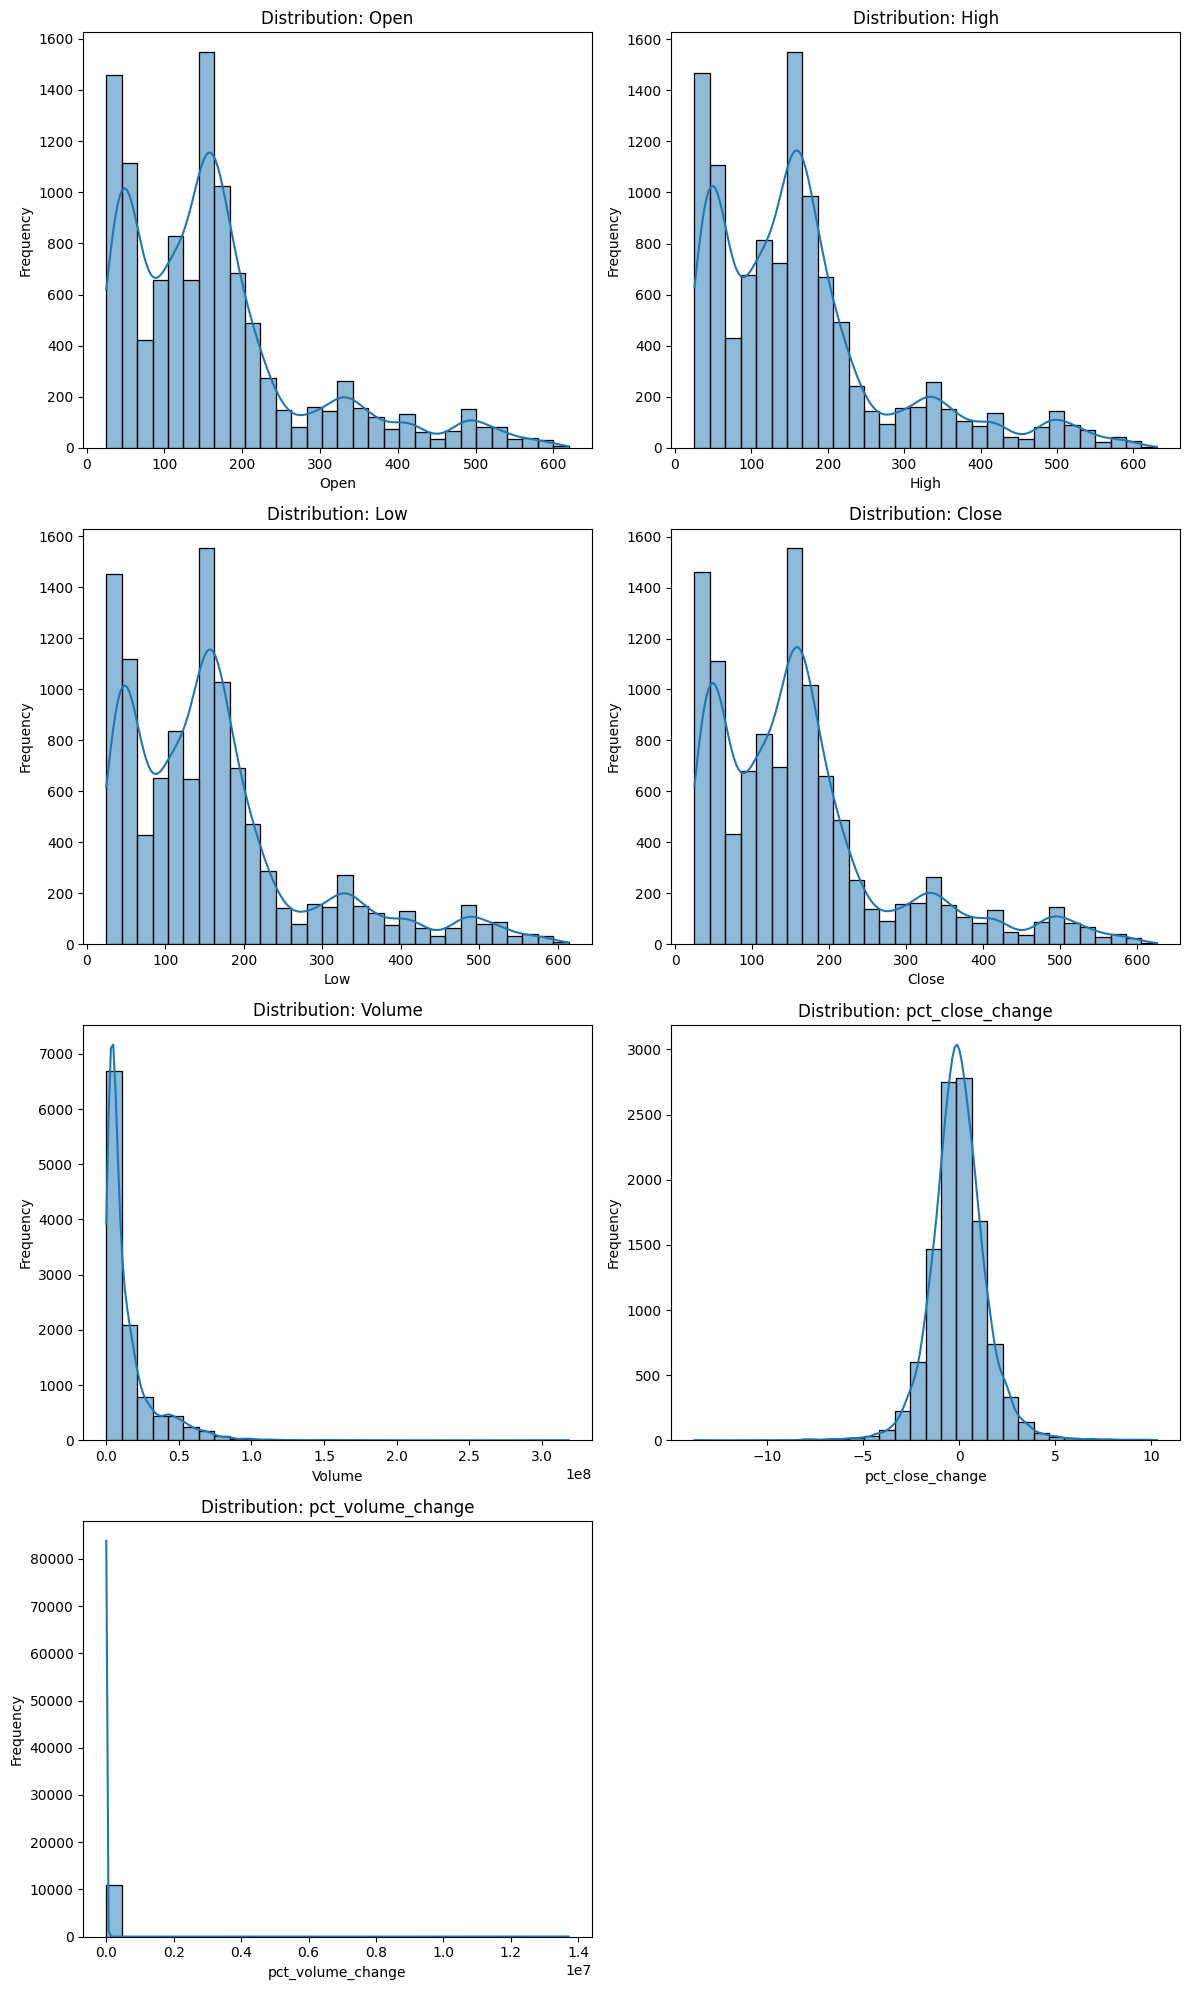

Plot saved to: images\numeric_columns_distribution.png


In [38]:
# Create directory and define output path
output_dir = 'images'
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, 'numeric_columns_distribution.png')

# Define numeric columns and grid dimensions
numeric_cols = [col for col in selected_columns if daily_data_df[col].nunique() > 2]
num_cols = len(numeric_cols)
grid_rows = math.ceil(num_cols / 2)
grid_cols = 2

# Plot distributions for numeric columns
fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(12, grid_rows * 5))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.histplot(daily_data_df[col], kde=True, bins=30, ax=axes[i])
    axes[i].set_title(f"Distribution: {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequency")

# Turn off unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()

# Save and display the plot
plt.savefig(output_path, dpi=300)
plt.show()

print(f"Plot saved to: {output_path}")

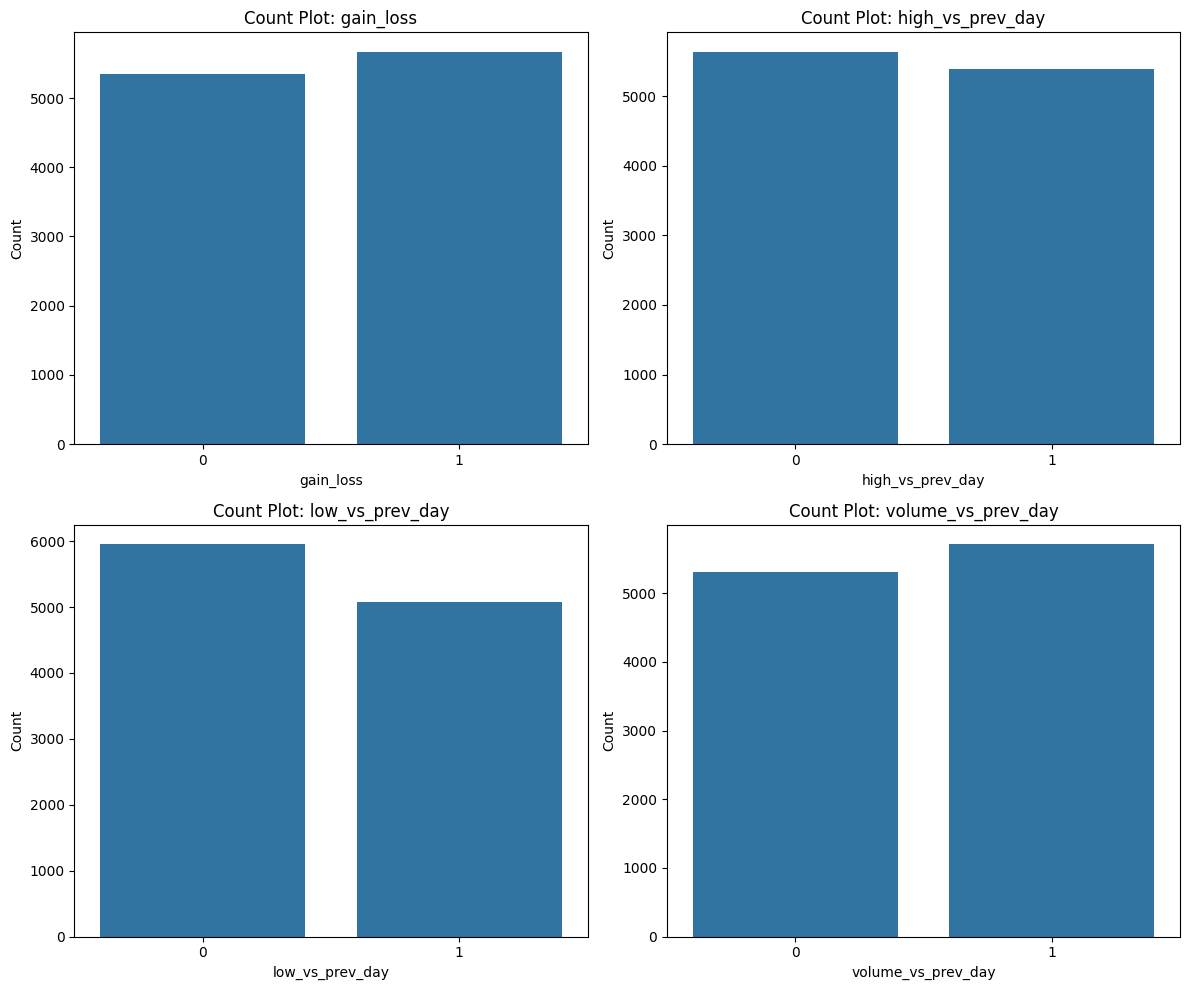

Plot saved to: images\binary_columns_count_plot.png


In [39]:
# Create directory and define output path
output_dir = 'images'
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, 'binary_columns_count_plot.png')

# Define binary columns
binary_cols = [col for col in selected_columns if daily_data_df[col].nunique() == 2]

# Create grid for count plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# Plot count plots for binary columns
for i, col in enumerate(binary_cols):
    sns.countplot(x=daily_data_df[col], ax=axes[i])
    axes[i].set_title(f"Count Plot: {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")

# Turn off unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()

# Save and display the plot
plt.savefig(output_path, dpi=300)
plt.show()

print(f"Plot saved to: {output_path}")

### Outlier Analysis

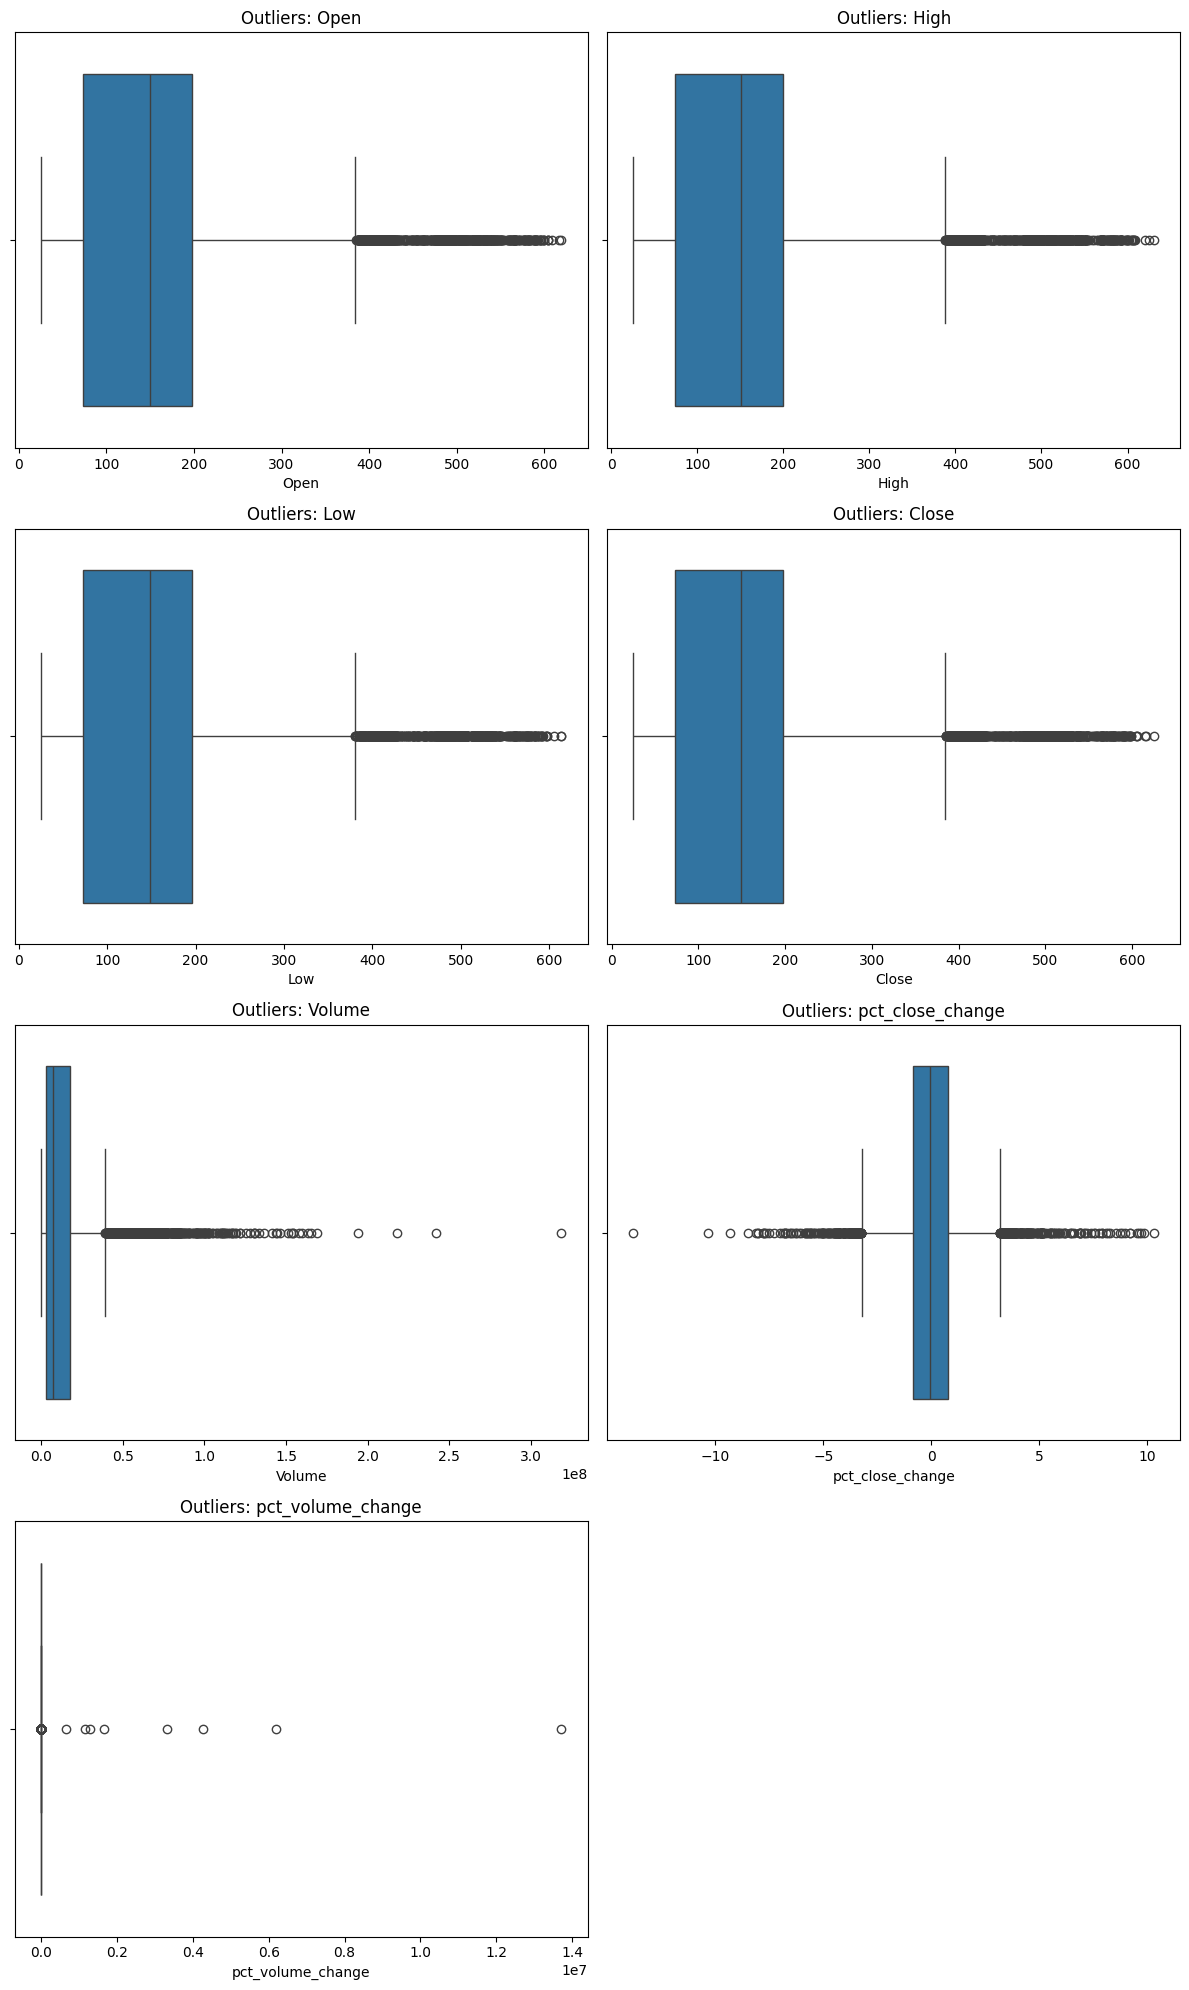

Plot saved to: images\numeric_columns_outliers_plot.png


In [40]:
# Create directory and define output path
output_dir = 'images'
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, 'numeric_columns_outliers_plot.png')

# Plot boxplots for numeric columns to visualize outliers
fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(12, grid_rows * 5))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.boxplot(x=daily_data_df[col], ax=axes[i])
    axes[i].set_title(f"Outliers: {col}")
    axes[i].set_xlabel(col)

# Turn off unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()

# Save and display the plot
plt.savefig(output_path, dpi=300)
plt.show()

print(f"Plot saved to: {output_path}")

### Determine if Outliers are True Outliers Statistically

In [41]:
# Perform Generalized ESD test for outliers
def generalized_esd_test(data, max_outliers):
    data = np.array(data)
    n = len(data)
    outliers = []
    for i in range(max_outliers):
        mean = np.mean(data)
        std = np.std(data, ddof=1)
        abs_deviation = np.abs(data - mean)
        R = np.max(abs_deviation) / std
        p = 1 - 0.05 / (2 * (n - i))
        t_critical = t.ppf(p, n - i - 2)
        lambda_critical = (n - i - 1) * t_critical / np.sqrt((n - i - 2 + t_critical**2) * (n - i))
        if R > lambda_critical:
            outlier = data[np.argmax(abs_deviation)]
            outliers.append(outlier)
            data = data[data != outlier]
        else:
            break
    return outliers

# Identify outliers using z-scores
def z_score_outliers(data, threshold=3):
    z_scores = np.abs(zscore(data))
    return data[z_scores > threshold]

# Summarize outlier analysis results for numeric columns
summary = []

for col in numeric_cols:
    data = daily_data_df[col].dropna()
    esd_outliers = generalized_esd_test(data, max_outliers=5)
    z_outliers = z_score_outliers(data)
    summary.append({
        'Column': col,
        'ESD_Outliers': len(esd_outliers),
        'Z_Outliers': len(z_outliers),
        'ESD_Values': esd_outliers[:5],  # Truncated for clarity
        'Z_Values': z_outliers[:5].tolist()  # Truncated for clarity
    })

# Convert to DataFrame and display
summary_df = pd.DataFrame(summary)
summary_df

,Column,ESD_Outliers,Z_Outliers,ESD_Values,Z_Values
0,Open,0,190,[],"[619.58, 616.895, 609.0, 598.69, 603.895]"
1,High,0,184,[],"[624.48, 630.73, 619.8, 607.6418, 605.5]"
2,Low,0,189,[],"[613.775, 613.9225, 605.2, 596.15, 590.8501]"
3,Close,0,182,[],"[614.67, 625.25, 615.81, 605.45, 596.69]"
4,Volume,5,205,"[318582200.0, 241805100.0, 217881309.0, 194031...","[318582200.0, 117397952.0, 98480100.0, 8247560..."
5,pct_close_change,5,147,"[-13.7892, 10.3132, -10.3497, 9.8562, 9.7286]","[5.0604, -6.7729, -5.6337, 5.0442, 4.9158]"
6,pct_volume_change,5,8,"[13714425.0, 6187835.503, 4272271.0526, 333349...","[1287781.8681, 652021.9355, 3333491.3978, 1371..."


***The Generalized ESD test detected only 5 outliers out of 11,066 data points across Volume, pct_close_change, and pct_volume_change, while finding none in Open, High, Low, and Close, indicating that nearly all data points fall within expected variability. Although the Z-score method flagged more outliers (147–205), these likely reflect normal market fluctuations rather than true anomalies. Given the inherent volatility of financial data and the minimal proportion of ESD outliers (0.045%), these points likely represent significant market events, such as price spikes or trading surges, which are essential for a comprehensive analysis. Retaining them preserves the dataset's real-world complexity.***

### Multivariate Analysis

In [42]:
# Correlation Matrix
correlation_matrix = daily_data_df[selected_columns].corr().round(4)
correlation_matrix

,Open,High,Low,Close,Volume,gain_loss,high_vs_prev_day,low_vs_prev_day,volume_vs_prev_day,pct_close_change,pct_volume_change
Open,1.0000,0.9999,0.9999,0.9998,-0.1830,0.0074,0.0001,-0.0155,0.0041,-0.0006,0.0182
High,0.9999,1.0000,0.9999,0.9999,-0.1821,0.0136,-0.0013,-0.0182,0.0054,-0.0006,0.0187
Low,0.9999,0.9999,1.0000,0.9999,-0.1838,0.0143,-0.0032,-0.0170,0.0029,-0.0007,0.0182
Close,0.9998,0.9999,0.9999,1.0000,-0.1828,0.0202,-0.0061,-0.0212,0.0042,-0.0007,0.0187
Volume,-0.1830,-0.1821,-0.1838,-0.1828,1.0000,-0.0001,0.0064,-0.0210,0.1085,-0.0087,-0.0103
gain_loss,0.0074,0.0136,0.0143,0.0202,-0.0001,1.0000,-0.3389,-0.2982,-0.0068,-0.0111,0.0005
high_vs_prev_day,0.0001,-0.0013,-0.0032,-0.0061,0.0064,-0.3389,1.0000,0.5843,0.0562,0.4972,-0.0113
low_vs_prev_day,-0.0155,-0.0182,-0.0170,-0.0212,-0.0210,-0.2982,0.5843,1.0000,-0.0960,0.5251,-0.0101
volume_vs_prev_day,0.0041,0.0054,0.0029,0.0042,0.1085,-0.0068,0.0562,-0.0960,1.0000,-0.0178,0.0185
pct_close_change,-0.0006,-0.0006,-0.0007,-0.0007,-0.0087,-0.0111,0.4972,0.5251,-0.0178,1.0000,-0.0097


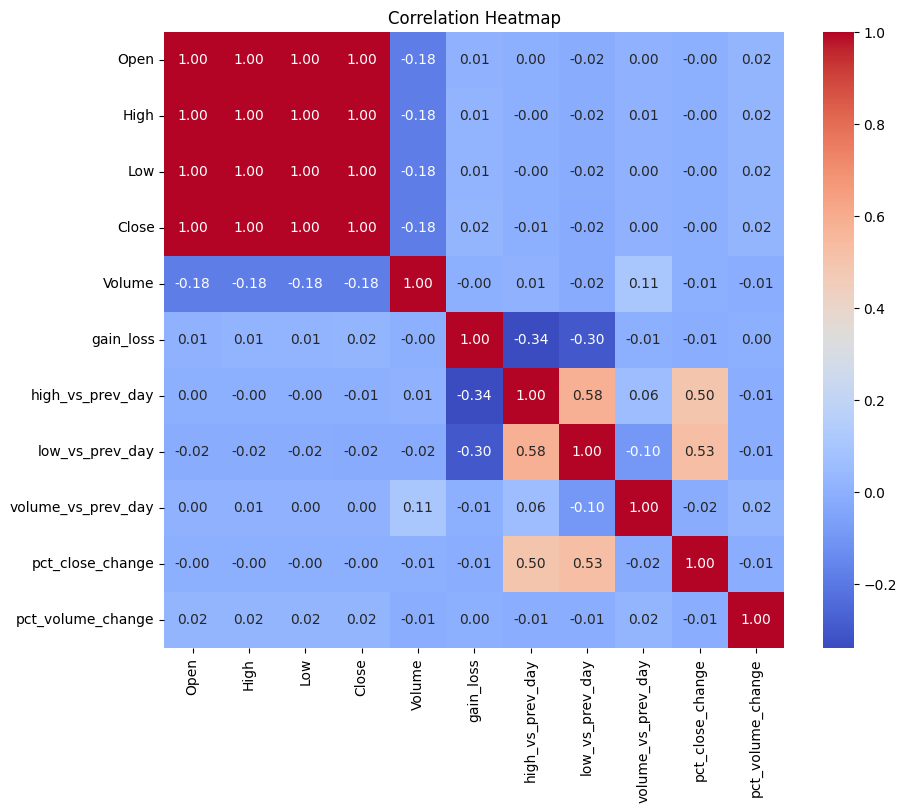

Heatmap saved to: images\correlation_heatmap.png


In [43]:
# Create directory and define output path
output_dir = 'images'
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, 'correlation_heatmap.png')

# Heatmap to visualize correlations
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")

# Save and display the plot
plt.savefig(output_path, dpi=300)
plt.show()

print(f"Heatmap saved to: {output_path}")

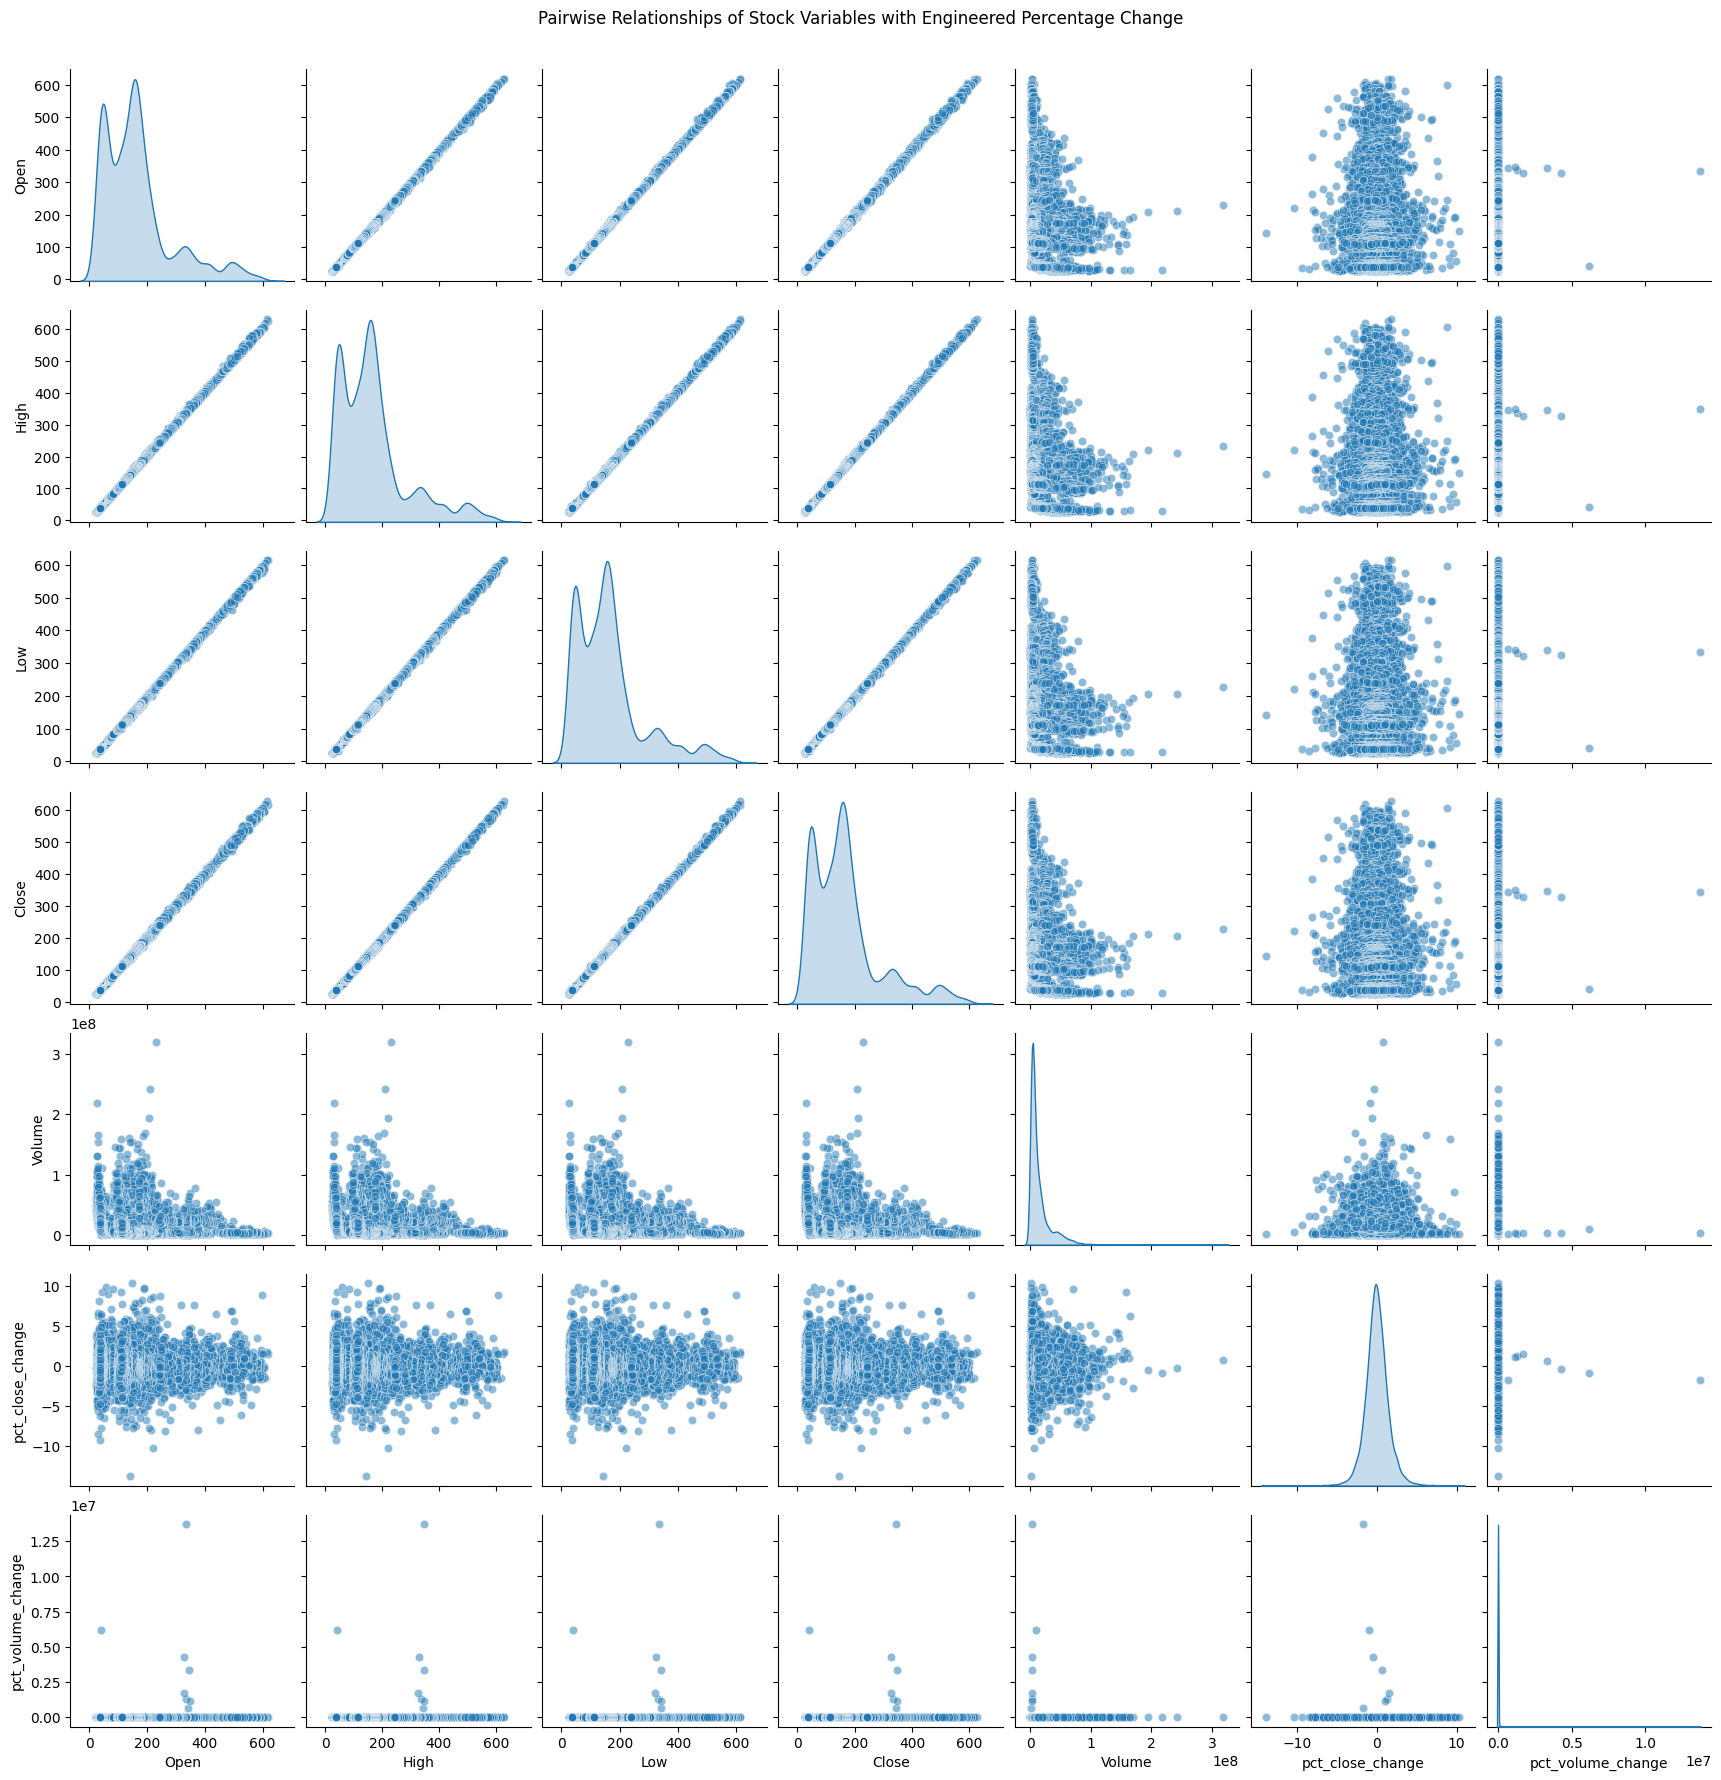

Pairplot saved to: images\pairwise_relationships.png


In [44]:
# Create directory and define output path
output_dir = 'images'
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, 'pairwise_relationships.png')

# Pairplot for numeric columns
pairplot = sns.pairplot(daily_data_df[numeric_cols], diag_kind="kde", plot_kws={'alpha': 0.5})
pairplot.fig.suptitle("Pairwise Relationships of Stock Variables with Engineered Percentage Change", y=1.02)

# Save and display the plot
pairplot.savefig(output_path, dpi=300)
plt.show()

print(f"Pairplot saved to: {output_path}")

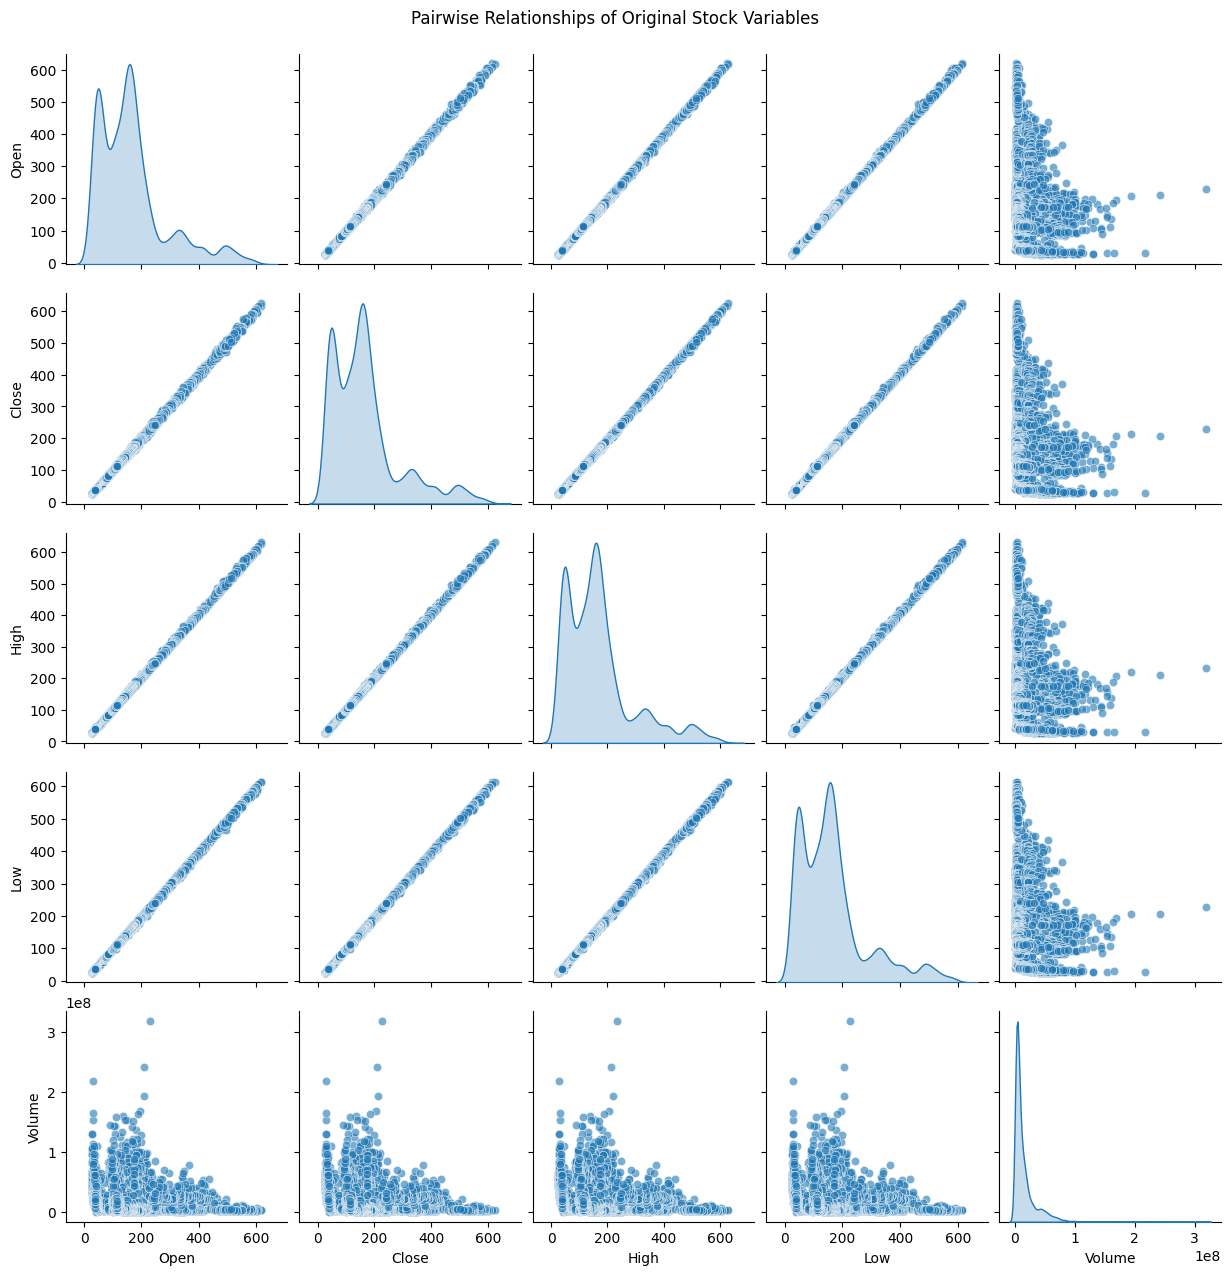

Scatterplot matrix saved to: images\scatterplot_matrix.png


In [45]:
# Create directory and define output path
output_dir = 'images'
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, 'scatterplot_matrix.png')

# Scatterplot matrix for selected columns
scatter_cols = ["Open", "Close", "High", "Low", "Volume"]
scatterplot = sns.pairplot(daily_data_df[scatter_cols], diag_kind="kde", plot_kws={'alpha': 0.6})
scatterplot.fig.suptitle("Pairwise Relationships of Original Stock Variables", y=1.02)

# Save and display the plot
scatterplot.savefig(output_path, dpi=300)
plt.show()

print(f"Scatterplot matrix saved to: {output_path}")

In [46]:
# Ensure the 'images' directory exists
os.makedirs('images', exist_ok=True)

# Create a new directed graph and specify the folder for the output
erd = Digraph('Entity-Relationship Diagram', filename='images/erd', format='png')

# Define the Stock Data entity
erd.node('StockData', 
         '''<
         <TABLE BORDER="0" CELLBORDER="1" CELLSPACING="0" CELLPADDING="8" STYLE="ROUNDED">
            <TR><TD COLSPAN="2" BGCOLOR="#4682B4" ALIGN="CENTER"><FONT COLOR="white" FACE="Helvetica" POINT-SIZE="16"><B>Stock Data</B></FONT></TD></TR>
            <TR><TD ALIGN="LEFT" BGCOLOR="#D3EAFD"><B>Primary Key</B></TD><TD ALIGN="LEFT">Symbol</TD></TR>
            <TR><TD ALIGN="LEFT">Date</TD><TD ALIGN="LEFT">Attribute</TD></TR>
            <TR><TD ALIGN="LEFT">Open</TD><TD ALIGN="LEFT">Attribute</TD></TR>
            <TR><TD ALIGN="LEFT">Close</TD><TD ALIGN="LEFT">Attribute</TD></TR>
            <TR><TD ALIGN="LEFT">High</TD><TD ALIGN="LEFT">Attribute</TD></TR>
            <TR><TD ALIGN="LEFT">Low</TD><TD ALIGN="LEFT">Attribute</TD></TR>
            <TR><TD ALIGN="LEFT">Volume</TD><TD ALIGN="LEFT">Attribute</TD></TR>
         </TABLE>
         >''', shape='plaintext')

# Define the 8-K Disclosures entity
erd.node('EightKDisclosures', 
         '''<
         <TABLE BORDER="0" CELLBORDER="1" CELLSPACING="0" CELLPADDING="8" STYLE="ROUNDED">
            <TR><TD COLSPAN="2" BGCOLOR="#FFA500" ALIGN="CENTER"><FONT COLOR="white" FACE="Helvetica" POINT-SIZE="16"><B>8-K Disclosures</B></FONT></TD></TR>
            <TR><TD ALIGN="LEFT" BGCOLOR="#FFE4B5"><B>Primary Key</B></TD><TD ALIGN="LEFT">Ticker</TD></TR>
            <TR><TD ALIGN="LEFT">Filing Type</TD><TD ALIGN="LEFT">Attribute</TD></TR>
            <TR><TD ALIGN="LEFT">Filing URL</TD><TD ALIGN="LEFT">Attribute</TD></TR>
            <TR><TD ALIGN="LEFT">Accession Number</TD><TD ALIGN="LEFT">Attribute</TD></TR>
            <TR><TD ALIGN="LEFT">Disclosure Date</TD><TD ALIGN="LEFT">Attribute</TD></TR>
            <TR><TD ALIGN="LEFT">Section</TD><TD ALIGN="LEFT">Attribute</TD></TR>
            <TR><TD ALIGN="LEFT">Processed Disclosure Text</TD><TD ALIGN="LEFT">Attribute</TD></TR>
         </TABLE>
         >''', shape='plaintext')

# Add the relationship between Stock Data and 8-K Disclosures
erd.edge('StockData', 'EightKDisclosures', label='Maps: Symbol → Ticker', fontname="Helvetica", fontsize="10", color="#2F4F4F")

# Render the ERD and save it in the 'images' folder
erd.render(view=False)

'images\\erd.png'

In [47]:
# Ensure the 'images' directory exists
os.makedirs('images', exist_ok=True)

# Create a new directed graph and specify the folder for the output
dfd = Digraph('DataFlowDiagram', filename='images/dfd', format='png')

# Set global graph attributes for professional styling
dfd.attr(rankdir='TB', size='6,10')  # Layout top to bottom for vertical flow
dfd.attr('node', fontname='Arial', fontsize='12')
dfd.attr('edge', fontname='Arial', fontsize='10', color='black')

# External Entities
dfd.node('User', '''<
    <TABLE BORDER="0" CELLBORDER="1" CELLSPACING="2" CELLPADDING="14" HEIGHT="60" BGCOLOR="#ECF0F1">
        <TR><TD ALIGN="CENTER" VALIGN="MIDDLE"><B>User</B></TD></TR>
    </TABLE>>''', shape='plaintext')

dfd.node('MarketstackAPI', '''<
    <TABLE BORDER="0" CELLBORDER="1" CELLSPACING="2" CELLPADDING="14" HEIGHT="60" BGCOLOR="#ECF0F1">
        <TR><TD ALIGN="CENTER" VALIGN="MIDDLE"><B>Marketstack API</B></TD></TR>
    </TABLE>>''', shape='plaintext')

dfd.node('SECAPI', '''<
    <TABLE BORDER="0" CELLBORDER="1" CELLSPACING="2" CELLPADDING="14" HEIGHT="60" BGCOLOR="#ECF0F1">
        <TR><TD ALIGN="CENTER" VALIGN="MIDDLE"><B>SEC API</B></TD></TR>
    </TABLE>>''', shape='plaintext')

# Processes
dfd.node('P1', '''<
    <TABLE BORDER="0" CELLBORDER="1" CELLSPACING="2" CELLPADDING="14" HEIGHT="60" BGCOLOR="#D6EAF8">
        <TR><TD ALIGN="CENTER" VALIGN="MIDDLE"><B>Fetch Stock Data</B></TD></TR>
    </TABLE>>''', shape='plaintext')

dfd.node('P2', '''<
    <TABLE BORDER="0" CELLBORDER="1" CELLSPACING="2" CELLPADDING="14" HEIGHT="60" BGCOLOR="#D6EAF8">
        <TR><TD ALIGN="CENTER" VALIGN="MIDDLE"><B>Fetch 8-K Disclosures</B></TD></TR>
    </TABLE>>''', shape='plaintext')

dfd.node('P3', '''<
    <TABLE BORDER="0" CELLBORDER="1" CELLSPACING="2" CELLPADDING="14" HEIGHT="60" BGCOLOR="#D6EAF8">
        <TR><TD ALIGN="CENTER" VALIGN="MIDDLE"><B>Merge Datasets</B></TD></TR>
    </TABLE>>''', shape='plaintext')

dfd.node('P4', '''<
    <TABLE BORDER="0" CELLBORDER="1" CELLSPACING="2" CELLPADDING="14" HEIGHT="60" BGCOLOR="#D6EAF8">
        <TR><TD ALIGN="CENTER" VALIGN="MIDDLE"><B>Generate Insights</B></TD></TR>
    </TABLE>>''', shape='plaintext')

# Data Stores
dfd.node('DS1', '''<
    <TABLE BORDER="0" CELLBORDER="1" CELLSPACING="2" CELLPADDING="14" HEIGHT="60" BGCOLOR="#D5F5E3">
        <TR><TD ALIGN="CENTER" VALIGN="MIDDLE"><B>Stock Data CSV</B></TD></TR>
    </TABLE>>''', shape='plaintext')

dfd.node('DS2', '''<
    <TABLE BORDER="0" CELLBORDER="1" CELLSPACING="2" CELLPADDING="14" HEIGHT="60" BGCOLOR="#D5F5E3">
        <TR><TD ALIGN="CENTER" VALIGN="MIDDLE"><B>8-K Disclosures CSV</B></TD></TR>
    </TABLE>>''', shape='plaintext')

# Data Flows
dfd.edge('User', 'P1', label='Request Stock Data')
dfd.edge('MarketstackAPI', 'P1', label='Stock Data')
dfd.edge('P1', 'DS1', label='Save Stock Data')
dfd.edge('User', 'P2', label='Request 8-K Data')
dfd.edge('SECAPI', 'P2', label='8-K Data')
dfd.edge('P2', 'DS2', label='Save 8-K Data')
dfd.edge('DS1', 'P3', label='Read Stock Data')
dfd.edge('DS2', 'P3', label='Read 8-K Data')
dfd.edge('P3', 'P4', label='Merged Data')
dfd.edge('P4', 'User', label='Insights/Visualizations')

# Render the DFD and save it in the 'images' folder
dfd.render(view=True)

'images\\dfd.png'

In [48]:
# Save the cleaned 'eight_k_sections_df' DataFrame to CSV
eight_k_sections_df.to_csv('cleaned_eight_k_sections_df.csv', index=False)

# Save the cleaned 'daily_data_df' DataFrame to CSV
daily_data_df.to_csv('cleaned_daily_data_df.csv', index=False)